### 데이터를 준비하자!
---
trade.csv  
위 파일은 미리 준비되어 있습니다. 클라우드 셸을 열어 다음과 같이 작업 디렉터리를 만들고 데이터를 연결해 주세요.

```
$ mkdir -p ~/aiffel/data_preprocess/
$ ln -s ~/data/ ~/aiffel/data_preprocess/
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

준비된 trade.csv 파일은 관세청 수출입 무역 통계 에서 가공한 데이터입니다.  
특정 국가에 대한 월별 수출입 건수와 금액(단위:천 불(USD 1,000))이 있습니다. 무역수지는 수출금액-수입금액이 됩니다.

In [2]:
import os

csv_file_path = os.getenv('HOME')+'/aiffel/data_preprocess/data/trade.csv'
trade = pd.read_csv(csv_file_path) 
trade.head()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지,기타사항
0,2015년 01월,중국,116932.0,12083947.0,334522.0,8143271.0,3940676.0,NaN
1,2015년 01월,미국,65888.0,5561545.0,509564.0,3625062.0,1936484.0,NaN
2,2015년 01월,일본,54017.0,2251307.0,82480.0,3827247.0,-1575940.0,NaN
3,2015년 02월,중국,86228.0,9927642.0,209100.0,6980874.0,2946768.0,NaN
4,2015년 02월,미국,60225.0,5021264.0,428678.0,2998216.0,2023048.0,NaN


### 학습 목표
---
- 중복된 데이터를 찾아 제거할 수 있고, 결측치(missing data)를 제거하거나 채워 넣을 수 있습니다.
- 데이터를 정규화시킬 수 있습니다.
- 이상치(outlier)를 찾고, 이를 처리할 수 있습니다.
- 범주형 데이터를 원-핫 인코딩할 수 있습니다.
- 연속적인 데이터를 구간으로 나눠 범주형 데이터로 변환할 수 있습니다.

### 학습 목차
---
1. 결측치(Missing Data)
2. 중복된 데이터
3. 이상치(Outlier)
4. 정규화(Normalization)
5. 원-핫 인코딩(One-Hot Encoding)
6. 구간화(Binning)

### 1-2. 결측치(Missing Data)

**현실에서 여러분이 다룰 데이터는 결측치를 포함하고 있는 경우가 많습니다. 물론 데이터를 수집하는 과정에서 누락되지 않도록 하는 것이 더 좋은 방법이지만 이미 결측치가 존재한다면 이를 처리해 주어야 합니다.
결측치를 처리하는 방법은 크게 두 가지가 있습니다.**
1. 결측치가 있는 데이터를 제거한다.
2. 결측치를 어떤 값으로 대체한다. (결측치를 대체하는 방법은 다양한데, 데이터마다 특성을 반영하여 해결해야 합니다.)  

우선 결측치 여부를 먼저 살펴보겠습니다.

In [3]:
print('전체 데이터 건수:', len(trade))

전체 데이터 건수: 199


전체 데이터 건수에서 각 컬럼별 값이 있는 데이터 수를 빼주면 컬럼별 결측치의 개수

In [4]:
print('컬럼별 결측치 개수')
len(trade) - trade.count()

컬럼별 결측치 개수


기간        0
국가명       0
수출건수      3
수출금액      4
수입건수      3
수입금액      3
무역수지      4
기타사항    199
dtype: int64

'기타사항'을 보시면 전부 결측치라는 것을 알 수 있습니다. 이는 아무런 정보가 없는 컬럼이므로 삭제

In [5]:
trade = trade.drop('기타사항', axis=1)
trade.head()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,2015년 01월,중국,116932.0,12083947.0,334522.0,8143271.0,3940676.0
1,2015년 01월,미국,65888.0,5561545.0,509564.0,3625062.0,1936484.0
2,2015년 01월,일본,54017.0,2251307.0,82480.0,3827247.0,-1575940.0
3,2015년 02월,중국,86228.0,9927642.0,209100.0,6980874.0,2946768.0
4,2015년 02월,미국,60225.0,5021264.0,428678.0,2998216.0,2023048.0


기타사항 컬럼이 삭제된 것을 확인해 보았습니다.
이제 결측치가 있는 행을 살펴보겠습니다.

**`DataFrame.isnull()`은 데이터마다 결측치 여부를 True, False로 반환합니다. `DataFrame.any(axis=1)`는 행마다 하나라도 True가 있으면 True, 그렇지 않으면 False를 반환합니다.**

두 메서드를 조합하여 결측치가 하나라도 있는 행을 찾아보겠습니다.

**DataFrame에 `isnull()`을 적용하고, 여기도 또 `any(axis=1)` 메서드를 적용합니다. 이 결과, '각 행이 결측치가 하나라도 있는지' 여부를 불리언 값으로 가진 Series가 출력됩니다.**

In [6]:
trade.isnull()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
194,False,False,False,False,False,False,False
195,False,False,False,False,False,False,False
196,False,False,True,True,True,True,True
197,False,False,True,True,True,True,True


In [7]:
trade.isnull().any(axis=1)

0      False
1      False
2      False
3      False
4      False
       ...  
194    False
195    False
196     True
197     True
198     True
Length: 199, dtype: bool

trade.isnull().any(axis=1)을 다시 DataFrame에 넣어주면 값이 True인 데이터만 추출해 줍니다.

In [8]:
trade[trade.isnull().any(axis=1)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,NaN,1141118.0,5038739.0,NaN
196,2020년 06월,중국,NaN,NaN,NaN,NaN,NaN
197,2020년 06월,미국,NaN,NaN,NaN,NaN,NaN
198,2020년 06월,일본,NaN,NaN,NaN,NaN,NaN


ndex 191 데이터는 수출금액과 무역수지 컬럼이 빠져있고, index 196, 197, 198은 기간, 국가명을 제외하고 모두 결측치입니다. 이 경우 index 191 데이터는 삭제하기보다 특정 값으로 대체하는 것이 좋습니다. 반면 index 196, 197, 198은 제거하는 것이 바람직합니다.

우선 '수출건수', '수출금액', '수입건수', '수입금액', '무역수지' 열이 모두 결측치인 index 196, 197, 198을 삭제하겠습니다.

DataFrame의 dropna는 결측치를 삭제해 주는 메서드입니다. subset 옵션으로 특정 컬럼들을 선택했습니다. how 옵션으로 선택한 컬럼 전부가 결측치인 행을 삭제하겠다는 의미로 'all'을 선택합니다('any': 하나라도 결측치인 경우). inplace 옵션으로 해당 DataFrame 내부에 바로 적용시켰습니다.

In [9]:
trade.dropna(how='all', subset=['수출건수', '수출금액', '수입건수', '수입금액', '무역수지'], inplace=True)
print("👽 It's okay, no biggie.")

👽 It's okay, no biggie.


In [10]:
# Q. 결측치가 하나라도 존재하는 데이터를 다시 확인해봅시다.
# [[YOUR CODE]]
trade[trade.isnull().any(axis=1)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,NaN,1141118.0,5038739.0,NaN


index 191과 같이 수치형 데이터를 보완할 방법은 많습니다.

1. 특정 값을 지정해 줄 수 있습니다. 그러나 결측치가 많은 경우, 모두 같은 값으로 대체한다면 데이터의 분산이 실제보다 작아지는 문제가 생길 수 있습니다.
2. 평균, 중앙값 등으로 대체할 수 있습니다. 1번에서 특정 값으로 대체했을 때와 마찬가지로 결측치가 많은 경우 데이터의 분산이 실제보다 작아지는 문제가 발생할 수 있습니다.
3. 다른 데이터를 이용해 예측값으로 대체할 수 있습니다. 예를 들어 머신러닝 모델로 2020년 4월 미국의 예측값을 만들고, 이 값으로 결측치를 보완할 수 있습니다.
4. 시계열 특성을 가진 데이터의 경우 앞뒤 데이터를 통해 결측치를 대체할 수 있습니다. 예를 들어 기온을 측정하는 센서 데이터에서 결측치가 발생할 경우, 전후 데이터의 평균으로 보완할 수 있습니다.  

index 191은 4번 방법을 통해 보완하도록 하겠습니다.

trade 데이터셋에서 국가명인 미국이며 2020년 3월과 5월 데이터셋을 출력합니다.

In [11]:
trade[(trade['국가명']=='미국')&((trade['기간']=='2020년 03월')|(trade['기간']=='2020년 05월'))]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
188,2020년 03월,미국,97117.0,7292838.0,1368345.0,5388338.0,1904500.0
194,2020년 05월,미국,126598.0,4600726.0,1157163.0,4286873.0,313853.0


실행 결과 각 항목의 인덱스는 188, 194임을 얻었습니다. index 191의 수출금액 컬럼값을 이전 달과 다음 달의 평균으로 채우도록 합니다.

In [12]:
trade.loc[191, '수출금액'] = (trade.loc[188, '수출금액'] + trade.loc[194, '수출금액'] )/2
trade.loc[[191]]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,5946782.0,1141118.0,5038739.0,NaN


index 191의 무역수지 컬럼은 수출금액과 수입금액의 차이를 이용하여 채우도록 하겠습니다.

In [13]:
# Q. 무역수지 값을 채워주세요!
# [[YOUR CODE]]
trade.loc[191, '무역수지'] = trade.loc[191, '수출금액'] - trade.loc[191, '수입금액']
trade.loc[[191]]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,5946782.0,1141118.0,5038739.0,908043.0


다른 방법으로도 index 191을 채우는 연습을 해보세요!

In [14]:
trade_ex = trade

# [Playground] 여러 가지 방법으로 결측치를 채우는 연습을 해보세요.
# [[YOUR CODE]]
# 보간법을 사용하여 결측치 채우기
trade_ex['수출금액'] = trade['수출금액'].interpolate()

# 무역수지 컬럼도 보간법 사용
trade_ex['무역수지'] = trade['무역수지'].interpolate()

# index 191의 결과 출력
trade_ex.loc[[191]]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,5946782.0,1141118.0,5038739.0,908043.0


지금까지 데이터가 수치형인 경우 결측치를 삭제하거나 대체하는 방법을 실습해 보았습니다. 데이터가 범주형인 경우는 어떻게 해야 할까요? 이는 수치형일 때와 유사합니다.

1. 특정 값을 지정해줄 수 있습니다. 예를 들어 ‘기타’, ‘결측’과 같이 새로운 범주를 만들어 결측치를 채울 수 있습니다.
2. 최빈값 등으로 대체합니다. 결측치가 많은 경우 최빈값이 지나치게 많아질 수 있으므로 결측치가 많을 때는 다른 방법을 사용하는 것이 좋습니다.
3. 다른 데이터를 이용해 예측값으로 대체할 수 있습니다.
4. 시계열 특성을 가진 데이터의 경우 앞뒤 데이터를 통해 결측치를 대체할 수 있습니다. 예를 들어 특정인의 2019년 직업이 결측치이고, 2018년과 2020년 직업이 일치한다면 그 값으로 보완할 수 있습니다. 만약 다르다면 둘 중 하나로 보완하도록 합니다.

데이터를 수집하는 과정에서 중복된 데이터가 생길 수 있습니다. 같은 값을 가진 데이터 없이 행(row)별로 값이 유일해야 한다면 중복된 데이터를 제거해야 합니다.

우선 중복된 데이터를 확인합니다. DataFrame.duplicated()는 데이터 중복 여부를 불리언 값으로 반환해 줍니다.

In [15]:
trade.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
191    False
192    False
193    False
194    False
195    False
Length: 196, dtype: bool

In [16]:
trade[trade.duplicated()]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
187,2020년 03월,중국,248059.0,10658599.0,358234.0,8948918.0,1709682.0


In [17]:
trade[(trade['기간']=='2020년 03월')&(trade['국가명']=='중국')]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
186,2020년 03월,중국,248059.0,10658599.0,358234.0,8948918.0,1709682.0
187,2020년 03월,중국,248059.0,10658599.0,358234.0,8948918.0,1709682.0


index 186, 187이 중복되어 있습니다.  
pandas에서는 DataFrame.drop_duplicates를 통해 중복된 데이터를 손쉽게 삭제할 수 있습니다.

In [18]:
trade.drop_duplicates(inplace=True)
print("👽 It's okay, no biggie.")

👽 It's okay, no biggie.


DataFrame.drop_duplicates를 좀 더 자세히 살펴볼까요?  
다음과 같이 id와 name을 컬럼으로 갖는 df가 있다고 해봅시다.

In [19]:
df = pd.DataFrame({'id':['001', '002', '003', '004', '002'], 
                   'name':['Park Yun', 'Kim Sung', 'Park Jin', 'Lee Han', 'Kim Min']})
df

,id,name
0,001,Park Yun
1,002,Kim Sung
2,003,Park Jin
3,004,Lee Han
4,002,Kim Min


id가 002인 데이터가 2개 있습니다. id가 사람마다 unique 하다고 할 때, 둘 중 하나는 삭제해야 합니다.  
index가 클수록 나중에 들어온 데이터이고, 사용자가 이름을 수정했을 때 업데이트가 되지 않고 삽입이 되어 생긴 문제라고 가정합니다. 즉, id가 중복된 경우 맨 나중에 들어온 값만 남겨야 합니다.  

DataFrame.drop_duplicates의 subset, keep 옵션을 통해 손쉽게 중복을 제거할 수 있습니다.

DataFrame.drop_duplicates
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html

subset:  
subset은 중복을 확인할 열(또는 열들)을 지정하는 데 사용됩니다.  
기본값은 None이며, 이 경우 모든 열을 기준으로 중복을 검사합니다.  
예를 들어, subset='id'라고 하면 id 컬럼만을 기준으로 중복을 검사하여 중복된 행을 제거합니다.  
여러 개의 열을 사용할 수도 있으며, 이 경우 subset=['col1', 'col2']와 같이 리스트로 지정할 수 있습니다.  


keep:   
keep은 중복된 행들 중 어느 것을 남길지 지정하는 옵션입니다.  
'first' (기본값): 첫 번째로 나타난 중복 행을 남기고 나머지는 제거합니다.  
'last': 마지막으로 나타난 중복 행을 남기고 나머지는 제거합니다.  
False: 모든 중복된 행을 제거합니다.

In [20]:
# Q. 링크의 공식 문서를 참고해서,
# id가 중복된 경우 나중에 들어온 값만 남기는 코드를 작성해보세요!
# ('Kim Sung' 항목이 삭제되어야 합니다.)

# [[YOUR CODE]]
df = df.drop_duplicates(subset='id', keep='last')
df

,id,name
0,001,Park Yun
2,003,Park Jin
3,004,Lee Han
4,002,Kim Min


1-4. 이상치(Outlier)
trade 데이터에서 큰 값을 가지는 이상치가 있다고 가정해 봅시다. 이상치란 대부분 값의 범위에서 벗어나 극단적으로 크거나 작은 값을 의미합니다. Min-Max Scaling 해보면 대부분의 값은 0에 가깝고 이상치만 1에 가까운 값을 가지게 될 것입니다. 이렇게 몇 개의 이상치 때문에 대부분 값의 차이는 의미가 거의 없어지게 됩니다. 극단적인 값이 생기는 경우를 제외하고 데이터를 고려하고 싶은 경우 이상치를 제거하고 분석합니다.

그렇다면 이상치를 어떻게 찾아내야 할까요? 현실에서 이상치를 찾는 것(anomaly detection) 자체가 큰 분야입니다.

가장 먼저 생각해 볼 수 있는 간단하고 자주 사용되는 방법은 평균과 표준편차를 이용하는 z score 방법입니다.
평균을 빼주고 표준편차로 나눠 z score
(
X
−
μ
/
σ
)
를 계산합니다. 그리고 z score가 특정 기준을 넘어서는 데이터에 대해 이상치라고 판단합니다. 기준을 작게 하면 이상치라고 판단하는 데이터가 많아지고, 기준을 크게 하면 이상치라고 판단하는 데이터가 적어집니다.

이상치를 판단한 뒤 어떻게 해야 할까요?

1. 가장 간단한 방법으로 이상치를 삭제할 수 있습니다. 이상치를 원래 데이터에서 삭제하고, 이상치끼리 따로 분석하는 방안도 있습니다.
2. 이상치를 다른 값으로 대체할 수 있습니다. 데이터가 적으면 이상치를 삭제하기보다 다른 값으로 대체하는 것이 나을 수 있습니다. 예를 들어 최댓값, 최솟값을 설정해 데이터의 범위를 제한할 수 있습니다.
3. 혹은 결측치와 마찬가지로 다른 데이터를 활용하여 예측 모델을 만들어 예측값을 활용할 수도 있습니다.
4. 아니면 binning을 통해 수치형 데이터를 범주형으로 바꿀 수도 있습니다.

### z-score method
---
이제 우리 데이터를 처리해 봅시다. 이상치인 데이터의 인덱스를 리턴하는 outlier라는 함수를 만들었습니다. 데이터프레임 df, 컬럼 col, 기준 z를 인풋으로 받습니다.

- abs(df[col] - np.mean(df[col])) : 데이터에서 평균을 빼준 것에 절대값을 취합니다.
- abs(df[col] - np.mean(df[col]))/np.std(df[col]) : 위에서 얻은 값을 표준편차로 나눠줍니다.
- df[abs(df[col] - np.mean(df[col]))/np.std(df[col])>z].index: 값이 z보다 큰 데이터의 인덱스를 추출합니다.

In [21]:
def outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col]))/np.std(df[col])>z].index
print("👽 It's okay, no biggie.")

👽 It's okay, no biggie.


In [22]:
trade.loc[outlier(trade, '무역수지', 1.5)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
6,2015년 03월,중국,117529.0,11868032.0,234321.0,7226911.0,4641121.0
75,2017년 02월,중국,159062.0,11118131.0,188555.0,6600637.0,4517495.0
80,2017년 03월,일본,65093.0,2395932.0,165734.0,5157589.0,-2761657.0
96,2017년 09월,중국,183442.0,13540683.0,295443.0,8443414.0,5097269.0
99,2017년 10월,중국,137873.0,12580474.0,244977.0,7932403.0,4648071.0
101,2017년 10월,일본,63510.0,1847999.0,127696.0,4418583.0,-2570584.0
102,2017년 11월,중국,421194.0,14000887.0,307790.0,9253318.0,4747569.0
105,2017년 12월,중국,218114.0,13848364.0,290347.0,8600132.0,5248232.0
114,2018년 03월,중국,232396.0,13576667.0,267249.0,8412516.0,5164151.0
116,2018년 03월,일본,80142.0,2603450.0,159601.0,5226141.0,-2622691.0


In [23]:
# Q. 무역수지 값을 기준으로 z=2일 때 이상치 데이터를 출력해보세요.
# [[YOUR CODE]]
trade.loc[outlier(trade, '무역수지', 2)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
129,2018년 08월,중국,199010.0,14401521.0,280033.0,8525532.0,5875989.0
132,2018년 09월,중국,171328.0,14590529.0,280337.0,7889890.0,6700639.0


In [24]:
# Q. 무역수지 값을 기준으로 z=3일 때 이상치 데이터를 출력해보세요.
# [[YOUR CODE]]
trade.loc[outlier(trade, '무역수지', 3)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지


무역수지의 이상치를 확인하는데 기준 되는 값이 클수록 이상치가 적어지는 것을 확인할 수 있습니다.
이제 not_outlier라는 함수를 통해 무역수지가 이상치 값이 아닌 데이터만 추출하도록 하겠습니다.

In [25]:
# Q. not_outlier() 함수를 구현하세요.
# [[YOUR CODE]]
def not_outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col])) / np.std(df[col]) <= z].index
print("👽 It's okay, no biggie.")

👽 It's okay, no biggie.


In [26]:
trade.loc[not_outlier(trade, '무역수지', 1.5)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,2015년 01월,중국,116932.0,12083947.0,334522.0,8143271.0,3940676.0
1,2015년 01월,미국,65888.0,5561545.0,509564.0,3625062.0,1936484.0
2,2015년 01월,일본,54017.0,2251307.0,82480.0,3827247.0,-1575940.0
3,2015년 02월,중국,86228.0,9927642.0,209100.0,6980874.0,2946768.0
4,2015년 02월,미국,60225.0,5021264.0,428678.0,2998216.0,2023048.0
...,...,...,...,...,...,...,...
191,2020년 04월,미국,105360.0,5946782.0,1141118.0,5038739.0,908043.0
192,2020년 04월,일본,134118.0,1989323.0,141207.0,3989562.0,-2000239.0
193,2020년 05월,중국,185320.0,10746069.0,349007.0,8989920.0,1756149.0
194,2020년 05월,미국,126598.0,4600726.0,1157163.0,4286873.0,313853.0


### IQR method
---
하지만 이상치를 찾는 방법에는 위에 설명한 z-score 방법만 있는 것은 아닙니다. 그리고 z-score 방법은 몇 가지 뚜렷한 한계점을 가지고 있습니다. z-score 방법의 대안으로 사분위 범위수 IQR(Interquartile range) 로 이상치를 알아내는 방법을 알아보겠습니다.

이해를 돕기 위해 아웃라이어가 포함된 임의의 데이터를 만들어보겠습니다.






In [27]:
np.random.seed(2020)
data = np.random.randn(100)  # 평균 0, 표준편차 1의 분포에서 100개의 숫자를 샘플링한 데이터 생성
data = np.concatenate((data, np.array([8, 10, -3, -5])))      # [8, 10, -3, -5])를 데이터 뒤에 추가함
data

array([-1.76884571,  0.07555227, -1.1306297 , -0.65143017, -0.89311563,
       -1.27410098, -0.06115443,  0.06451384,  0.41011295, -0.57288249,
       -0.80133362,  1.31203519,  1.27469887, -1.2143576 ,  0.31371941,
       -1.44482142, -0.3689613 , -0.76922658,  0.3926161 ,  0.05729383,
        2.08997884,  0.04197131, -0.04834072, -0.51315392, -0.08458928,
       -1.21545008, -1.41293073, -1.48691055,  0.38222486,  0.937673  ,
        1.77267804,  0.87882801,  0.33171912, -0.30603567,  1.24026615,
       -0.21562684,  0.15592948,  0.09805553,  0.83209585,  2.04520542,
       -0.31681392, -1.31283291, -1.75445746,  0.10209408, -1.36150208,
        0.48178488, -0.20832874, -0.09186351,  0.70268816,  0.10365506,
        0.62123638,  0.95411497,  2.03781352, -0.48445122,  0.2071549 ,
        1.64424216, -0.4882074 , -0.01782826,  0.46891556,  0.27987266,
       -0.64664972, -0.54406002, -0.16008985,  0.03781172,  1.03383296,
       -1.23096117, -1.24673665,  0.29572055,  2.1409624 , -0.92

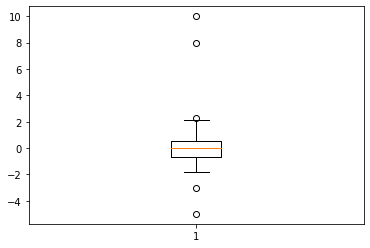

In [28]:
fig, ax = plt.subplots()
ax.boxplot(data)
plt.show()

우리는 사분위 범위수 IQR(Interquartile range)을 이용하여 이상치를 찾아낼 수 있습니다.

IQR=Q 
3
​
 −Q 
1
​
 
즉, IQR은 제 3사분위수에서 제 1사분위 값을 뺀 값으로 데이터의 중간 50%의 범위라고 생각하시면 됩니다. 
Q
1
−
1.5
∗
I
Q
R
Q 
1
​
 −1.5∗IQR보다 왼쪽에 있거나, 
Q
3
+
1.5
∗
I
Q
R
Q 
3
​
 +1.5∗IQR 보다 오른쪽에 있는 경우 우리는 이상치라고 판단합니다.

아래 그림을 보면 이 식의 의미가 좀 더 와닿을 겁니다.

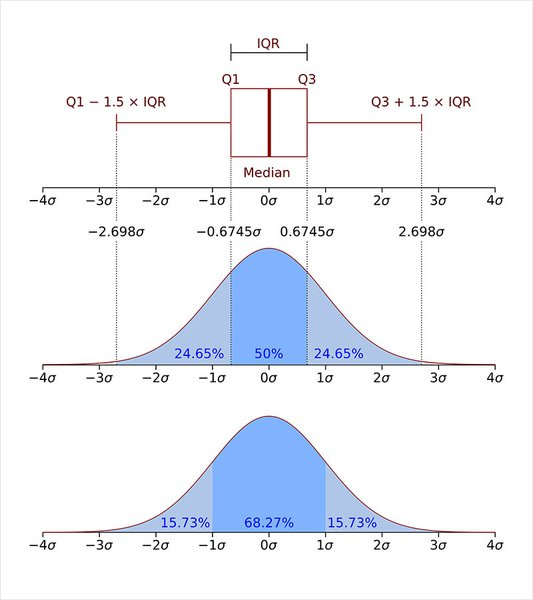

IQR을 구하기 위해 우선 제1사분위수와 제 3사분위수를 구합니다.

In [29]:
Q3, Q1 = np.percentile(data, [75 ,25])
IQR = Q3 - Q1
IQR

1.1644925829790964

IQR과 제 1사분위수, 제 3사분위수를 이용하여 이상치를 확인할 수 있습니다.

In [30]:
data[(Q1-1.5*IQR > data)|(Q3+1.5*IQR < data)]

array([ 2.31256634,  8.        , 10.        , -3.        , -5.        ])

위에서 z-score 방법과 IQR 방법에 대해서 알아보았습니다. 그럼 다음 링크의 아티클을 읽어보고 질문에 답해 봅시다.

이상치 탐지를 하는 세가지 방법 https://modulabs.co.kr/blog/outlier-detection/  

Q. 이 글에서 말하는 z-score 방법이 가지는 뚜렷한 단점 2가지가 무엇인가요?
1. 정규분포 가정: 데이터가 정규분포를 따른다는 가정 하에 사용되므로, 데이터가 정규분포가 아닌 경우 정확한 결과를 얻기 어렵습니다.
2. 이상치의 민감성: 데이터에 이상치가 많을 경우 평균과 표준 편차에 영향을 미쳐 Z-score 값이 부정확해질 수 있습니다.

① Robust하지 못합니다. 왜나하면 평균과 표준편차 자체가 이상치의 존재에 크게 영향을 받기 때문입니다.  
② 작은 데이터셋의 경우 z-score의 방법으로 이상치를 알아내기 어렵습니다. 특히 item이 12개 이하인 데이터셋에서는 불가능합니다.

무역수지를 기준으로 이상치를 찾는 실습을 해보도록 하겠습니다. 아래 코드에서 outlier2(df, col) 메서드를 구현해 보세요.

In [31]:
# Q. 사분위 범위수를 이용해서 이상치를 찾는 outlier2() 함수를 구현해보세요.
def outlier2(df, col):
    # [[YOUR CODE]]
    Q3, Q1 = np.percentile(df[col], [75 ,25])
    IQR = Q3 - Q1
    return df[(Q1-1.5*IQR > df[col])|(Q3+1.5*IQR < df[col])].index

outlier2(trade, '무역수지')

Int64Index([], dtype='int64')

In [32]:
trade.loc[outlier2(trade, '무역수지')]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지


### 1-5. 정규화(Normalization)

trade 데이터를 보면 수입건수, 수출건수와 수입금액, 수출금액, 무역수지는 단위가 다르다는 것을 알 수 있습니다.  

이처럼 컬럼마다 스케일이 크게 차이가 나는 데이터를 입력하면 머신러닝 모델 학습에 문제가 발생할 수 있습니다. 예를 들어 데이터의 범위가 0에서 1 사이인 컬럼 A과 1000에서 10000 사이인 컬럼 B가 있다고 생각해 봅시다. 이런 데이터를 클러스터링 한다고 가정해 봅시다. 데이터 간의 거리를 잴 때, 범위가 큰 컬럼 B의 값에만 영향을 크게 받을 것입니다. 다른 예시로 간단한 linear regression을 한다고 가정해 봅시다. 모델의 파라미터를 업데이트하는 과정에서 범위가 큰 컬럼 B의 파라미터만 집중적으로 업데이트하는 문제가 생길 수 있습니다. 그래서 일반적으로 컬럼 간에 범위가 크게 다를 경우 전처리 과정에서 데이터를 정규화합니다.  

정규화를 하는 방법은 다양하지만, 가장 잘 알려진 표준화(Standardization)와 Min-Max Scaling을 알아보도록 하겠습니다.

- Standardization

    - 데이터의 평균은 0, 분산은 1로 변환합니다.
    - Standardization은 보통 평균이 0이고 표준편차가 1일 때 사용합니다. 그렇기에 데이터가 가우시안 분포를 따를 경우 유용합니다.  
X
−
μ
/
σ


- Min-Max Scaling
    - 데이터의 최솟값은 0, 최댓값은 1로 변환합니다.
    - Min-Max Scaling은 피처의 범위가 다를 때 주로 사용하며 확률 분포를 모를 때 유용합니다.  
$\frac{X-X_{min}}{X_{max}-X_{min}}$


정규화 기법이 데이터의 분포를 어떻게 바꾸는지 살펴볼까요? 우선 임의의 데이터를 생성하고, 각각의 기법으로 데이터를 정규화시켜줍니다.

In [33]:
# 정규분포를 따라 랜덤하게 데이터 x를 생성합니다. 
x = pd.DataFrame({'A': np.random.randn(100)*4+4,
                 'B': np.random.randn(100)-1})
x

,A,B
0,6.205792,-1.485248
1,-0.604047,-0.727779
2,3.018785,-0.517099
3,3.323325,-0.414949
4,6.167679,-0.582630
...,...,...
95,5.062917,-1.122239
96,-0.166839,-2.487547
97,-4.230178,0.589513
98,-0.562115,0.779614


In [34]:
# 데이터 x를 Standardization 기법으로 정규화합니다. 
x_standardization = (x-x.mean())/x.std()
x_standardization

,A,B
0,0.559307,-0.314995
1,-1.132240,0.407499
2,-0.232338,0.608450
3,-0.156691,0.705884
4,0.549839,0.545945
...,...,...
95,0.275419,0.031252
96,-1.023639,-1.271014
97,-2.032961,1.663966
98,-1.121824,1.845290


In [35]:
# 데이터 x를 min-max scaling 기법으로 정규화합니다. 
x_min_max = (x-x.min())/(x.max()-x.min())
x_min_max

,A,B
0,0.607216,0.426240
1,0.267692,0.571821
2,0.448318,0.612312
3,0.463502,0.631944
4,0.605316,0.599717
...,...,...
95,0.550235,0.496008
96,0.289490,0.233606
97,0.086901,0.824995
98,0.269782,0.861531


다음 이미지는 데이터를 standardization 기법으로 정규화를 했을 때 분포가 어떻게 바뀌는지 보여줍니다. 즉, 각 컬럼의 평균은 0으로, 분산은 1로 데이터를 바꿔줍니다.

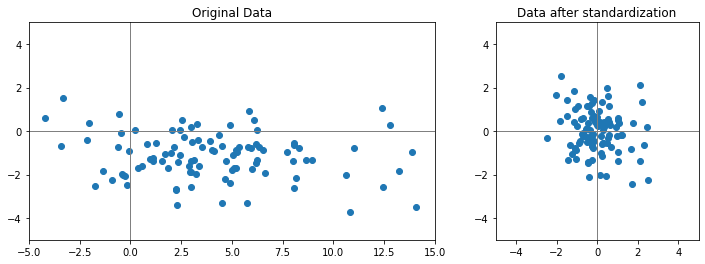

In [36]:
fig, axs = plt.subplots(1,2, figsize=(12, 4),
                        gridspec_kw={'width_ratios': [2, 1]})

axs[0].scatter(x['A'], x['B'])
axs[0].set_xlim(-5, 15)
axs[0].set_ylim(-5, 5)
axs[0].axvline(c='grey', lw=1)
axs[0].axhline(c='grey', lw=1)
axs[0].set_title('Original Data')

axs[1].scatter(x_standardization['A'], x_standardization['B'])
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)
axs[1].axvline(c='grey', lw=1)
axs[1].axhline(c='grey', lw=1)
axs[1].set_title('Data after standardization')

plt.show()

다음 이미지는 동일한 데이터를 min-max scaling 기법으로 정규화를 했을 때 분포가 어떻게 바뀌는지 보여줍니다. 즉, 각 컬럼의 최솟값은 0, 최댓값은 1로 바꿔줍니다.

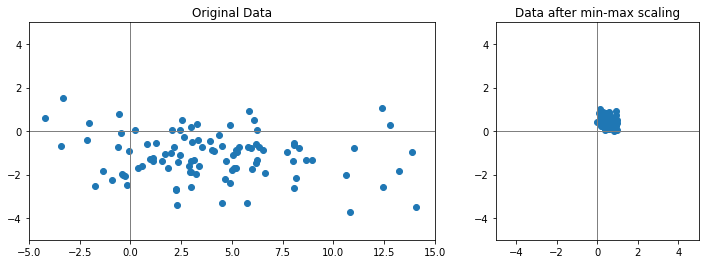

In [37]:
fig, axs = plt.subplots(1,2, figsize=(12, 4),
                        gridspec_kw={'width_ratios': [2, 1]})

axs[0].scatter(x['A'], x['B'])
axs[0].set_xlim(-5, 15)
axs[0].set_ylim(-5, 5)
axs[0].axvline(c='grey', lw=1)
axs[0].axhline(c='grey', lw=1)
axs[0].set_title('Original Data')

axs[1].scatter(x_min_max['A'], x_min_max['B'])
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)
axs[1].axvline(c='grey', lw=1)
axs[1].axhline(c='grey', lw=1)
axs[1].set_title('Data after min-max scaling')

plt.show()

그럼 우리가 가진 trade 데이터를 살펴봅시다.

### Standardization
---
우선 정규화를 시켜야 할 수치형 컬럼들을 cols 변수에 담은 후, 데이터에서 평균을 빼고, 표준편차로 나눠주도록 합니다.

In [38]:
# trade 데이터를 standardization 기법으로 정규화합니다. 
cols = ['수출건수', '수출금액', '수입건수', '수입금액', '무역수지']
trade_standardization = (trade[cols]-trade[cols].mean())/trade[cols].std()
trade_standardization.head()

,수출건수,수출금액,수입건수,수입금액,무역수지
0,-0.007488,1.398931,-0.163593,1.283660,1.256342
1,-0.689278,-0.252848,0.412529,-0.964444,0.401088
2,-0.847838,-1.091156,-0.993148,-0.863844,-1.097779
3,-0.417598,0.852853,-0.576399,0.705292,0.832209
4,-0.764918,-0.389673,0.146306,-1.276341,0.438027


standardization 방법으로 정규화시킨 trade_standardization을 확인해 보겠습니다. 각 컬럼의 평균들을 보면 거의 0에 가깝고, 표준편차는 1에 가까운 것을 확인하실 수 있습니다.

In [39]:
trade_standardization.describe()

,수출건수,수출금액,수입건수,수입금액,무역수지
count,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02
mean,-1.093143e-16,6.832142e-17,1.821904e-17,-5.465713e-17,2.277381e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.194976e-01,-1.231761e+00,-9.984408e-01,-1.276341e+00,-1.603764e+00
25%,-5.937426e-01,-1.041338e+00,-7.673625e-01,-7.911669e-01,-1.116765e+00
50%,-4.373265e-01,-1.564700e-01,-3.429346e-01,-4.137392e-01,1.426824e-01
75%,4.420459e-01,1.037200e+00,3.927781e-01,8.827841e-01,7.461637e-01
max,5.486317e+00,2.078416e+00,3.239068e+00,2.376092e+00,2.434109e+00


### Min-Max Scaling
---
데이터에서 최솟값을 빼주고, '최댓값-최솟값'으로 나눠줍니다.

In [40]:
# Q. trade 데이터를 min-max scaling 기법으로 정규화합니다.
trade[cols] =  (trade[cols] - trade[cols].min()) / (trade[cols].max() - trade[cols].min()) # [[YOUR CODE]]
trade.head()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,2015년 01월,중국,0.142372,0.794728,0.197014,0.700903,0.708320
1,2015년 01월,미국,0.035939,0.295728,0.332972,0.085394,0.496512
2,2015년 01월,일본,0.011187,0.042477,0.001249,0.112938,0.125310
3,2015년 02월,중국,0.078351,0.629759,0.099597,0.542551,0.603281
4,2015년 02월,미국,0.024131,0.254394,0.270146,0.000000,0.505660


In [41]:
trade.describe()

,수출건수,수출금액,수입건수,수입금액,무역수지
count,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.143541,0.372113,0.235620,0.349450,0.397180
std,0.156108,0.302099,0.235988,0.273790,0.247655
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050853,0.057527,0.054532,0.132836,0.120608
50%,0.075271,0.324844,0.154691,0.236172,0.432516
75%,0.212548,0.685450,0.328311,0.591147,0.581972
max,1.000000,1.000000,1.000000,1.000000,1.000000


주의!!

train 데이터와 test 데이터가 나눠져 있는 경우 train 데이터를 정규화시켰던 기준 그대로 test 데이터도 정규화시켜줘야 합니다.

In [42]:
train = pd.DataFrame([[10, -10], [30, 10], [50, 0]])
test = pd.DataFrame([[0, 1], [10, 10]])
print("👽 It's okay, no biggie.")

👽 It's okay, no biggie.


In [43]:
# Q. train 데이터와 test 데이터에 정규화를 적용해봅시다.
train_min = train.min()
train_max = train.max()

# 중요한 점은, test 데이터에 min-max scaling을 적용할 때도
# train 데이터 기준으로 수행해야 한다는 것입니다.
train_min_max = (train - train_min) / (train_max - train_min) # [[YOUR CODE]]
test_min_max = (test - train_min) / (train_max - train_min) # [[YOUR CODE]]

print("💫 It's okay, no biggie...")

💫 It's okay, no biggie...


In [44]:
train_min_max

,0,1
0,0.0,0.0
1,0.5,1.0
2,1.0,0.5


In [45]:
test_min_max

,0,1
0,-0.25,0.55
1,0.00,1.00


scikit-learn의 StandardScaler, MinMaxScaler를 사용하는 방법도 있습니다.

In [46]:
from sklearn.preprocessing import MinMaxScaler
train = [[10, -10], [30, 10], [50, 0]]
test = [[0, 1]]
scaler = MinMaxScaler()
print("👽 It's okay, no biggie.")

👽 It's okay, no biggie.


In [47]:
scaler.fit_transform(train)

array([[0. , 0. ],
       [0.5, 1. ],
       [1. , 0.5]])

In [48]:
scaler.transform(test)

array([[-0.25,  0.55]])

https://www.youtube.com/watch?v=FDCfw-YqWTE

이번 스텝에서 언급하지 않았지만, 로그 변환 등의 기법도 정규화와 함께 사용하면 도움이 될 수 있다는 것도 기억해 주세요!

### 1-6. 원-핫 인코딩(One-Hot Encoding)
이제 범주형 데이터인 국가명 컬럼을 다뤄보도록 하겠습니다.
머신러닝이나 딥러닝 프레임워크에서 범주형을 지원하지 않는 경우 원-핫 인코딩을 해야 합니다.

원-핫 인코딩이란 카테고리별 이진 특성을 만들어 해당하는 특성만 1, 나머지는 0으로 만드는 방법입니다. 그럼, pandas로 국가명 컬럼을 원-핫 인코딩을 해보겠습니다.

pandas에서 get_dummies 함수를 통해 손쉽게 원-핫 인코딩을 할 수 있습니다.

In [49]:
#trade 데이터의 국가명 컬럼 원본
print(trade['국가명'].head())  

# get_dummies를 통해 국가명 원-핫 인코딩
country = pd.get_dummies(trade['국가명'])
country.head()

0    중국
1    미국
2    일본
3    중국
4    미국
Name: 국가명, dtype: object


,미국,일본,중국
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,1
4,1,0,0


pd.concat 함수로 데이터프레임 trade와 country를 합쳐줍니다.

In [50]:
trade = pd.concat([trade, country], axis=1)
trade.head()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지,미국,일본,중국
0,2015년 01월,중국,0.142372,0.794728,0.197014,0.700903,0.708320,0,0,1
1,2015년 01월,미국,0.035939,0.295728,0.332972,0.085394,0.496512,1,0,0
2,2015년 01월,일본,0.011187,0.042477,0.001249,0.112938,0.125310,0,1,0
3,2015년 02월,중국,0.078351,0.629759,0.099597,0.542551,0.603281,0,0,1
4,2015년 02월,미국,0.024131,0.254394,0.270146,0.000000,0.505660,1,0,0


이제는 필요 없어진 국가명 컬럼을 삭제해 주고 나면 trade는 우리가 원하는 데이터프레임이 됩니다.

In [51]:
trade.drop(['국가명'], axis=1, inplace=True)
trade.head()

,기간,수출건수,수출금액,수입건수,수입금액,무역수지,미국,일본,중국
0,2015년 01월,0.142372,0.794728,0.197014,0.700903,0.708320,0,0,1
1,2015년 01월,0.035939,0.295728,0.332972,0.085394,0.496512,1,0,0
2,2015년 01월,0.011187,0.042477,0.001249,0.112938,0.125310,0,1,0
3,2015년 02월,0.078351,0.629759,0.099597,0.542551,0.603281,0,0,1
4,2015년 02월,0.024131,0.254394,0.270146,0.000000,0.505660,1,0,0


### 1-7. 구간화(Binning)
지금까지 trade 데이터를 다루면서 다양 전처리 기법을 배웠습니다. 이제 다른 전처리 기법을 배워보도록 하겠습니다.

salary에 소득 데이터가 있다고 합시다.

In [52]:
salary = pd.Series([4300, 8370, 1750, 3830, 1840, 4220, 3020, 2290, 4740, 4600, 
                    2860, 3400, 4800, 4470, 2440, 4530, 4850, 4850, 4760, 4500, 
                    4640, 3000, 1880, 4880, 2240, 4750, 2750, 2810, 3100, 4290, 
                    1540, 2870, 1780, 4670, 4150, 2010, 3580, 1610, 2930, 4300, 
                    2740, 1680, 3490, 4350, 1680, 6420, 8740, 8980, 9080, 3990, 
                    4960, 3700, 9600, 9330, 5600, 4100, 1770, 8280, 3120, 1950, 
                    4210, 2020, 3820, 3170, 6330, 2570, 6940, 8610, 5060, 6370,
                    9080, 3760, 8060, 2500, 4660, 1770, 9220, 3380, 2490, 3450, 
                    1960, 7210, 5810, 9450, 8910, 3470, 7350, 8410, 7520, 9610, 
                    5150, 2630, 5610, 2750, 7050, 3350, 9450, 7140, 4170, 3090])
print("👽 Almost there..")

👽 Almost there..


이 데이터를 구간별로 나누고자 합니다. 이러한 기법을 구간화(Data binning 혹은 bucketing)이라고 부릅니다.

아래 히스토그램과 같이 연속적인 데이터를 구간을 나눠 분석할 때 사용하는 방법입니다.

<AxesSubplot:>

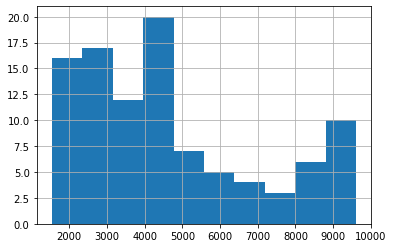

In [53]:
salary.hist()

pandas의 cut 과 qcut을 이용해 수치형 데이터를 범주형 데이터로 변형시키도록 하겠습니다.

cut을 사용하기 위해 우선 구간을 정해줍니다.

In [54]:
bins = [0, 2000, 4000, 6000, 8000, 10000]
print("👽 Almost there..")

👽 Almost there..


cut 함수에 데이터와 구간을 입력하면 데이터를 구간별로 나눠줍니다.

In [55]:
ctg = pd.cut(salary, bins=bins)
ctg

0      (4000, 6000]
1     (8000, 10000]
2         (0, 2000]
3      (2000, 4000]
4         (0, 2000]
          ...      
95     (2000, 4000]
96    (8000, 10000]
97     (6000, 8000]
98     (4000, 6000]
99     (2000, 4000]
Length: 100, dtype: category
Categories (5, interval[int64, right]): [(0, 2000] < (2000, 4000] < (4000, 6000] < (6000, 8000] < (8000, 10000]]

In [56]:
print('salary[0]:', salary[0])
print('salary[0]가 속한 카테고리:', ctg[0])

salary[0]: 4300
salary[0]가 속한 카테고리: (4000, 6000]


구간별로 값이 몇 개가 속해 있는지 value_counts()로 확인해 보겠습니다.

In [57]:
ctg.value_counts().sort_index()

(0, 2000]        12
(2000, 4000]     34
(4000, 6000]     29
(6000, 8000]      9
(8000, 10000]    16
dtype: int64

이렇게 특정 구간을 지정해 줘도 되고, 구간의 개수를 지정해 줄 수도 있습니다. bins 옵션에 정수를 입력하면 데이터의 최솟값에서 최댓값을 균등하게 bins 개수만큼 나눠줍니다.

In [58]:
# Q. 'bins' 옵션에 6을 입력해서 cut() 함수를 사용해보세요.
# [[YOUR CODE]]
ctg = pd.cut(salary, bins=6)
ctg

0      (4230.0, 5575.0]
1      (8265.0, 9610.0]
2     (1531.93, 2885.0]
3      (2885.0, 4230.0]
4     (1531.93, 2885.0]
            ...        
95     (2885.0, 4230.0]
96     (8265.0, 9610.0]
97     (6920.0, 8265.0]
98     (2885.0, 4230.0]
99     (2885.0, 4230.0]
Length: 100, dtype: category
Categories (6, interval[float64, right]): [(1531.93, 2885.0] < (2885.0, 4230.0] < (4230.0, 5575.0] < (5575.0, 6920.0] < (6920.0, 8265.0] < (8265.0, 9610.0]]

In [59]:
# Q. 구간별로 값이 몇 개가 있는지 확인해봅시다.
# [[YOUR CODE]]
ctg.value_counts().sort_index()

(1531.93, 2885.0]    27
(2885.0, 4230.0]     24
(4230.0, 5575.0]     21
(5575.0, 6920.0]      6
(6920.0, 8265.0]      7
(8265.0, 9610.0]     15
dtype: int64

qcut은 구간을 일정하게 나누는 것이 아니라 데이터의 분포를 비슷한 크기의 그룹으로 나눠줍니다.

In [60]:
ctg = pd.qcut(salary, q=5)
ctg

0       (3544.0, 4648.0]
1       (7068.0, 9610.0]
2     (1539.999, 2618.0]
3       (3544.0, 4648.0]
4     (1539.999, 2618.0]
             ...        
95      (2618.0, 3544.0]
96      (7068.0, 9610.0]
97      (7068.0, 9610.0]
98      (3544.0, 4648.0]
99      (2618.0, 3544.0]
Length: 100, dtype: category
Categories (5, interval[float64, right]): [(1539.999, 2618.0] < (2618.0, 3544.0] < (3544.0, 4648.0] < (4648.0, 7068.0] < (7068.0, 9610.0]]

In [61]:
print(ctg.value_counts().sort_index())
print(".\n.\n🛸 Well done!")

(1539.999, 2618.0]    20
(2618.0, 3544.0]      20
(3544.0, 4648.0]      20
(4648.0, 7068.0]      20
(7068.0, 9610.0]      20
dtype: int64
.
.
🛸 Well done!


### 마무리와 복습 과제
---
현실에서 여러분이 만날 데이터는 깨끗하지 않은 경우가 많습니다. 그래서 오늘은 표 데이터 전처리하는 방법을 배웠습니다. 어떤 내용을 다뤘는지 키워드로 살펴보겠습니다.

- 결측치(Missing Data)
- 중복된 데이터
- 이상치(Outlier)
- 정규화(Normalization)
- 원-핫 인코딩(One-Hot Encoding)
- 구간화(Binning)  

위의 내용을 배웠지만 모든 데이터에 일괄적으로 적용해야 하는 것은 아닙니다. 데이터 전처리는 데이터의 특성을 파악해서 해야 합니다. 그래서 다소 번거롭게 느껴질 수 있지만 꼭 해야 하는 과정인 만큼 복습해 보시기를 권합니다. 남는 시간 동안 아래 데이터셋의 전처리 과정을 진행해 보세요.

vgsales.csv  

들어가며 스텝에서 정상적으로 심볼릭 링크를 거셨다면 이미 여러분의 실습 폴더 ~/aiffel/data_preprocess/data 로 옮겨져있을 것입니다.

위 데이터의 출처는 캐글의 Video Game Sales 데이터셋입니다. 16,500개 이상의 비디오 게임에 대한 매출 정보 등이 담겨 있습니다. 혹시 게임을 좋아하시는 분께는 아주 흥미로운 데이터셋이 될지도 모르겠습니다. 위에 언급된 전처리 기법 중 다수를 시도해 볼 수 있는 데이터셋이므로, 오늘 배운 기법들이 본인의 것이 될 수 있도록 복습을 통해 다시 한번 개념을 다져보시기를 권합니다.

이외에도 여러분이 가진 표 데이터를 직접 전처리해 보시면 더욱 흥미롭게 하실 수 있습니다. 데이터가 없다면 공공데이터포털, 캐글에서 관심 있는 분야의 데이터를 찾아보시기 바랍니다.

수고하셨습니다! 🛸

Q. 수치형 데이터의 결측치를 채우는 방법은 어떤 것들이 있었나요?
- 특정값으로 채우기
- 머신러닝 모델로 예측값을 만들고, 이 값으로 결측치를 보완
- 앞뒤 데이터를 통해 결측치를 대체
- 평균값으로 채우기 (Mean Imputation)
- 중앙값으로 채우기 (Median Imputation)
- 최빈값으로 채우기 (Mode Imputation)
- 선형 보간법 (Linear Interpolation)

① 특정 값을 지정해 줄 수 있습니다. 그러나 결측치가 많은 경우, 모두 같은 값으로 대체한다면 데이터의 분산이 실제보다 작아지는 문제가 생길 수 있습니다.  
② 평균, 중앙값 등으로 대체할 수 있습니다. 1번에서 특정 값으로 대체했을 때와 마찬가지로 결측치가 많은 경우 데이터의 분산이 실제보다 작아지는 문제가 발생할 수 있습니다.  
③ 다른 데이터를 이용해 예측값으로 대체할 수 있습니다. 예를 들어 머신러닝 모델로 예측값을 만들고, 이 값으로 결측치를 보완할 수 있습니다.  
④ 시계열 특성을 가진 데이터의 경우 앞뒤 데이터를 통해 결측치를 대체할 수 있습니다. 예를 들어 기온을 측정하는 센서 데이터에서 결측치가 발생할 경우, 전후 데이터의 평균으로 보완할 수 있습니다.  

Q. 원-핫 인코딩은 분류(classification) 문제를 해결하는 딥러닝 모델을 구현할 때도 많이 사용됩니다. 예를 들어 0부터 9까지의 손글씨 숫자를 인식하는 모델이 있죠. 0부터 9까지의 카테고리를 원-핫 인코딩으로 표현할 때, 4와 7의 원-핫 인코딩 결과는 어떻게 될까요?
(원-핫 인코딩 결과의 각 특성은 순서대로 0부터 9에 해당된다고 가정합니다.)

- 숫자 4의 원-핫 인코딩 결과: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
- 숫자 7의 원-핫 인코딩 결과: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]